In [1]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle
import scipy.misc as smi

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.path.append('/work/code/repo/d-script/')
# d-script imports
from data_iters.minibatcher import MiniBatcher
from data_iters.iam_hdf5_iterator import IAM_MiniBatcher

from fielutil import *

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


### Data ingest

* Mini-batcher ingestion of data from HDF5 file specified at the beginning
* Direct image to do inference on, where for memory's sake, we've cut down the original image size

In [2]:
hdf5_file = '/memory/author_lines.hdf5'
num_forms_per_author=50; batch_size=32; num_authors=47; shingle_dim=(120,120); use_form=True

iam_m = IAM_MiniBatcher(hdf5_file, num_authors, num_forms_per_author, shingle_dim=shingle_dim, use_form=use_form, default_mode=MiniBatcher.TRAIN, batch_size=batch_size)
[X_test, Y_test] = iam_m.get_test_batch(batch_size*20)
X_test = np.expand_dims(X_test, 1)
X_test = randangle(X_test)
Y_test = to_categorical(Y_test, num_authors)

im = smi.imread('/fileserver/iam/forms/h07-025a.png')
im = 1.0-im/256.0
maxx, maxy = im.shape
maxx = maxx/3
maxy = maxy/3
halfim = im[ :maxx, :maxy ]
halfim = np.expand_dims( np.expand_dims( halfim, 0 ), 0 )

### Convert Original Dense Network to Convolutional Network

The following implementation is somewhat memory inefficient in that it first creates a network and then loads from that network into the feature network. What would be more efficient would be to read directly from the *.hdf5* file into the feature network. 

In [3]:
print "Loading original weights into GPU memory"
model = fielnet('../convnets/fielnet/fielnet.hdf5')
# When we flatten a convolutional layer, we need to know what the original dimensions were
flatten_shape = [layer.input_shape for layer in model.layers if type(layer)==Flatten][0]

print "Finished loading, now begin iterating through layers to copy over to feature model"
featmodel = Sequential()
for layer in model.layers:
    # The first layer
    if layer == model.layers[0] and type(layer)==Convolution2D:
        convshape = layer.get_weights()[0].shape[2:]
        convshape = (layer.get_weights()[0].shape[0],)+convshape
        featmodel.add(Convolution2D( *convshape, border_mode=layer.border_mode,
                                     input_shape=(1, maxx, maxy)))
    # From the layer "Flatten" on, we'll need to make changes to Dense layers
    elif type( layer ) == Flatten:
        convshape = flatten_shape[-2:]
    # Take the convolutional shape and add our newest layer
    elif type( layer ) == Dense:
        convshape = (layer.output_shape[-1],)+convshape
        Wl = layer.get_weights()[0]
        Wl = Wl.reshape( convshape[0], Wl.shape[0]/np.product(convshape[1:]), *convshape[1:] )
        bl = layer.get_weights()[1]
        featmodel.add(Convolution2D( *convshape, border_mode = 'valid', weights=[Wl,bl] ))
        convshape = (1,1)
    # Everything before the "Flatten", we'll just take from the original network
    else:
        featmodel.add( layer )
print "Model created and weights loaded in"

Loading original weights into GPU memory
Finished loading, now begin iterating through layers to copy over to feature model
Model created and weights loaded in


In [4]:
print "The first convolutional weight size expects an image of size "+str(maxx)+"x"+str(maxy)
featmodel.compile( loss='mse', optimizer='sgd' )

The first convolutional weight size expects an image of size 1180x826


In [5]:
halfimacts = featmodel.predict(halfim)

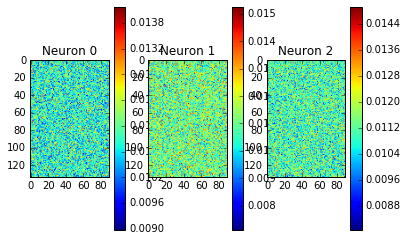

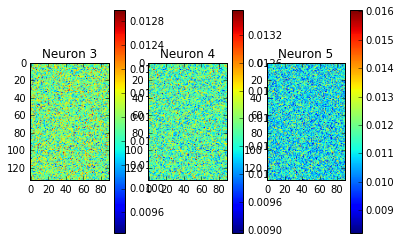

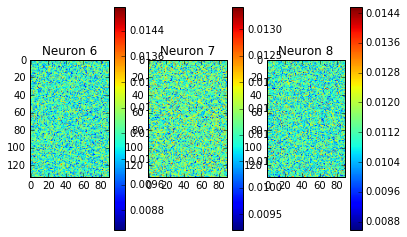

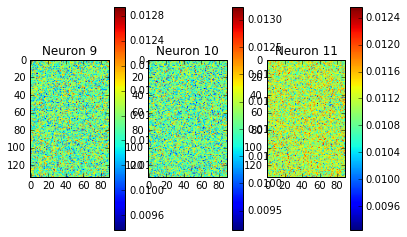

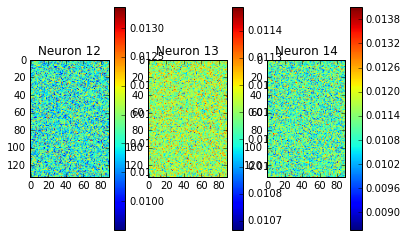

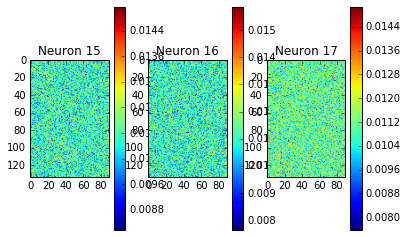

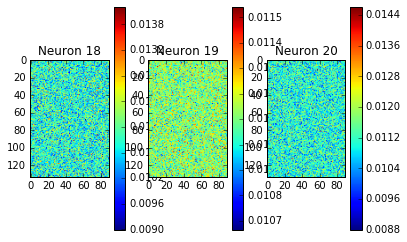

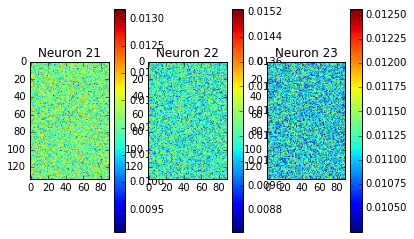

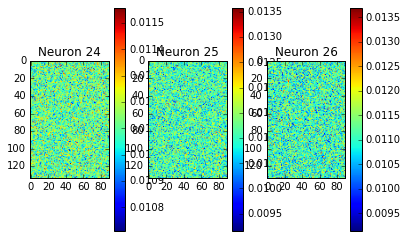

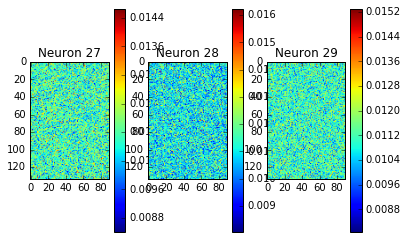

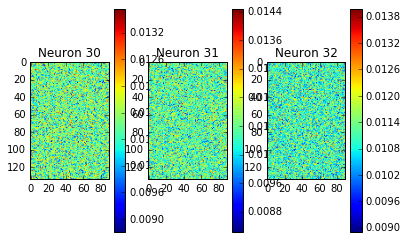

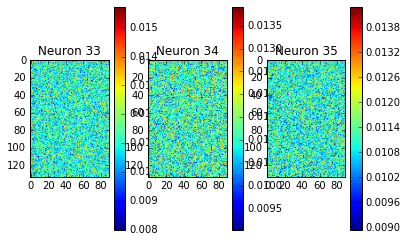

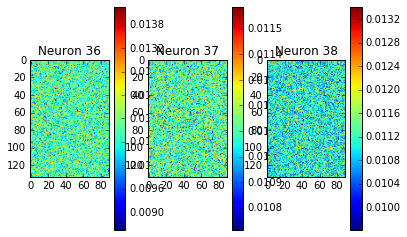

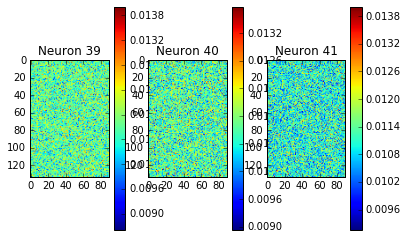

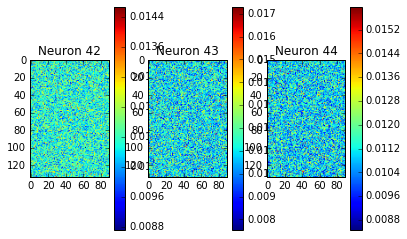

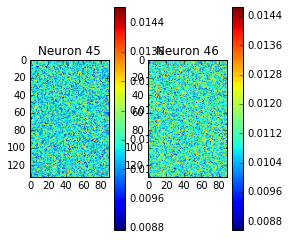

In [6]:
numcols = 3
numrows = 16

for j in xrange(numrows):
    plt.figure()
    for i in xrange(numcols):
        if (j*numcols+i) < halfimacts.shape[1]:
            plt.subplot(1,numcols,i+1)
            plt.imshow(halfimacts[0,j*numcols+i,:,:])
            plt.title('Neuron '+str(j*numcols+i))
            plt.colorbar()